In [1]:
import sys, os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import obspy
import obspy.signal.trigger as trigger
from obspy import taup, geodetics

## setting client
from obspy.clients.fdsn import Client
client = Client("USGS")

import datetime
from datetime import timedelta, datetime

In [2]:
def num_events_cum(mag_range, mag_col):
    if type(mag_col) != np.ndarray:
        mag_arr = mag_col.to_numpy()
    else:
        mag_arr = mag_col
    num_events_list = []
    for mag in mag_range:
        num_events_list.append(np.count_nonzero(np.where(mag_arr>mag)))
    return np.array(num_events_list)

def num_events_int(mag_range, mag_col):
    if type(mag_col) != np.ndarray:
        mag_arr = mag_col.to_numpy()
    else:
        mag_arr = mag_col
    num_events_list = []
    for mag in mag_range:
        num_events_list.append(np.count_nonzero(np.where((mag_arr>mag) & (mag_arr<=mag+1))))
    return np.array(num_events_list)

In [ ]:
n = 10000
days = 120
starttime = datetime(2000, 1, 1, 0, 0, 0)
endtime = datetime(2021, 12, 31, 23, 59, 59)

In [ ]:
randomstart = starttime + (endtime - starttime) * np.random.random_sample((n,))
with open("starttimes_temp.txt", "w") as f:
    for time in randomstart:
        f.write(f"{time.isoformat()}\n")

In [ ]:
mag_range = np.arange(0, 7, 1)
pdf_arr = np.zeros((n, 7), dtype = np.float32)
cdf_arr = np.zeros((n, 7), dtype = np.float32)

fig, ax = plt.subplots(1,2, figsize=(20, 8))
markersize = 10

for i, start in enumerate(randomstart[8000:]):
    cat_temp = client.get_events(starttime=start, endtime=start+timedelta(days=days), minmagnitude=0, 
                                      maxdepth = 0, mindepth = -50, 
                                      #latitude=19.6,longitude=-155.5, maxradius=180,
                                      eventtype = "earthquake")
    fname = str(start).replace(" ", "_").replace(":", "_").replace(".", "_")
    cat_temp.write("/home/iganesh/venusquakes/data_120days_2000_2021_10000/"+fname+".xml", format="QUAKEML")
    
    mag = []
    for ev in cat_temp:
        mag.append(ev.magnitudes[0].mag)
    mag_arr = np.array(mag)
    cdf_arr[i] = num_events_cum(mag_range, mag_arr)
    pdf_arr[i] = num_events_int(mag_range, mag_arr) 
    ax[1].plot(mag_range[np.where(cdf_arr[i]!=0.0)], cdf_arr[i][np.where(cdf_arr[i]!=0.0)], "-", c='silver', markersize = markersize, alpha = 0.5)
    ax[0].plot(mag_range[np.where(pdf_arr[i]!=0.0)]+0.5, pdf_arr[i][np.where(pdf_arr[i]!=0.0)], "-", c='silver', markersize = markersize, alpha = 0.5)
    
ax[0].plot(mag_range+0.5, np.mean(pdf_arr, axis = 0), "-", c='black')
ax[1].plot(mag_range, np.mean(cdf_arr, axis = 0), "-", c='black')
    
# ax[0].set_xlim(-0.5,7.5)
# ax[1].set_xlim(-0.5,7.5)
ax[0].set_xscale('log',base=10) 
ax[0].set_yscale('log',base=10)
ax[1].set_xscale('log',base=10) 
ax[1].set_yscale('log',base=10)
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=10)
# ax.legend(fontsize=12)
ax[0].set_xlabel("Magnitude" + r'$ M$', fontsize=12)
ax[0].set_ylabel(r'$ N / 120 days $', fontsize=12)
ax[0].set_title("probabality of occurence of an event of a certain magnitude", fontsize=15)
ax[1].set_xlabel("Magnitude" + r'$ M$', fontsize=12)
ax[1].set_ylabel(r'$ N / 120 days $', fontsize=12)
ax[1].set_title("probabality of occurence of an event of magnitude > M", fontsize=13)
plt.show()

np.savetxt("seismicity_interval_10000.txt", pdf_arr)
np.savetxt("seismicity_cumulative_10000.txt", cdf_arr)

In [ ]:
print(np.mean(pdf_arr, axis =0), np.mean(cdf_arr, axis = 0))

In [ ]:
mag_range = np.arange(0, 7.5, 0.5)
files = glob.glob("/home/iganesh/venusquakes/data_60days/*.xml")

fig, ax = plt.subplots(1,1, figsize=(10, 10))
markersize = 10

for file in files:
    mag = []
    cat = obspy.read_events(file)
    for ev in cat:
        mag.append(ev.magnitudes[0].mag)
    mag_arr = np.array(mag)
    num_events_60days = num_events_mag(mag_range, mag_arr)
    ax.plot(mag_range[np.where(num_events_60days!=0.0)], num_events_60days[np.where(num_events_60days!=0.0)], "-", c='grey', markersize = markersize, alpha = 0.5)

ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10)
ax.set_xlim(0,8)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=12)
ax.set_xlabel(r'$Mag$', fontsize=18)
ax.set_ylabel(r'$ N (Mag>Mag_0)$', fontsize=18)
plt.show()

In [ ]:
mag_range = np.arange(0, 7.5, 0.5)
files = glob.glob("/home/iganesh/venusquakes/data_60days/*.xml")

fig, ax = plt.subplots(1,1, figsize=(10, 10))
markersize = 10

for file in files:
    mag = []
    cat = obspy.read_events(file)
    for ev in cat:
        mag.append(ev.magnitudes[0].mag)
    mag_arr = np.array(mag)
    num_events_60days = num_events_mag(mag_range, mag_arr)
    ax.plot(mag_range[np.where(num_events_60days!=0.0)], num_events_60days[np.where(num_events_60days!=0.0)], "-", c='grey', markersize = markersize, alpha = 0.5)

# ax.set_xscale('log',base=10) 
# ax.set_yscale('log',base=10)
ax.set_xlim(0,8)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=12)
ax.set_xlabel(r'$Mag$', fontsize=18)
ax.set_ylabel(r'$ N/60 days > Mag)$', fontsize=18)
plt.show()

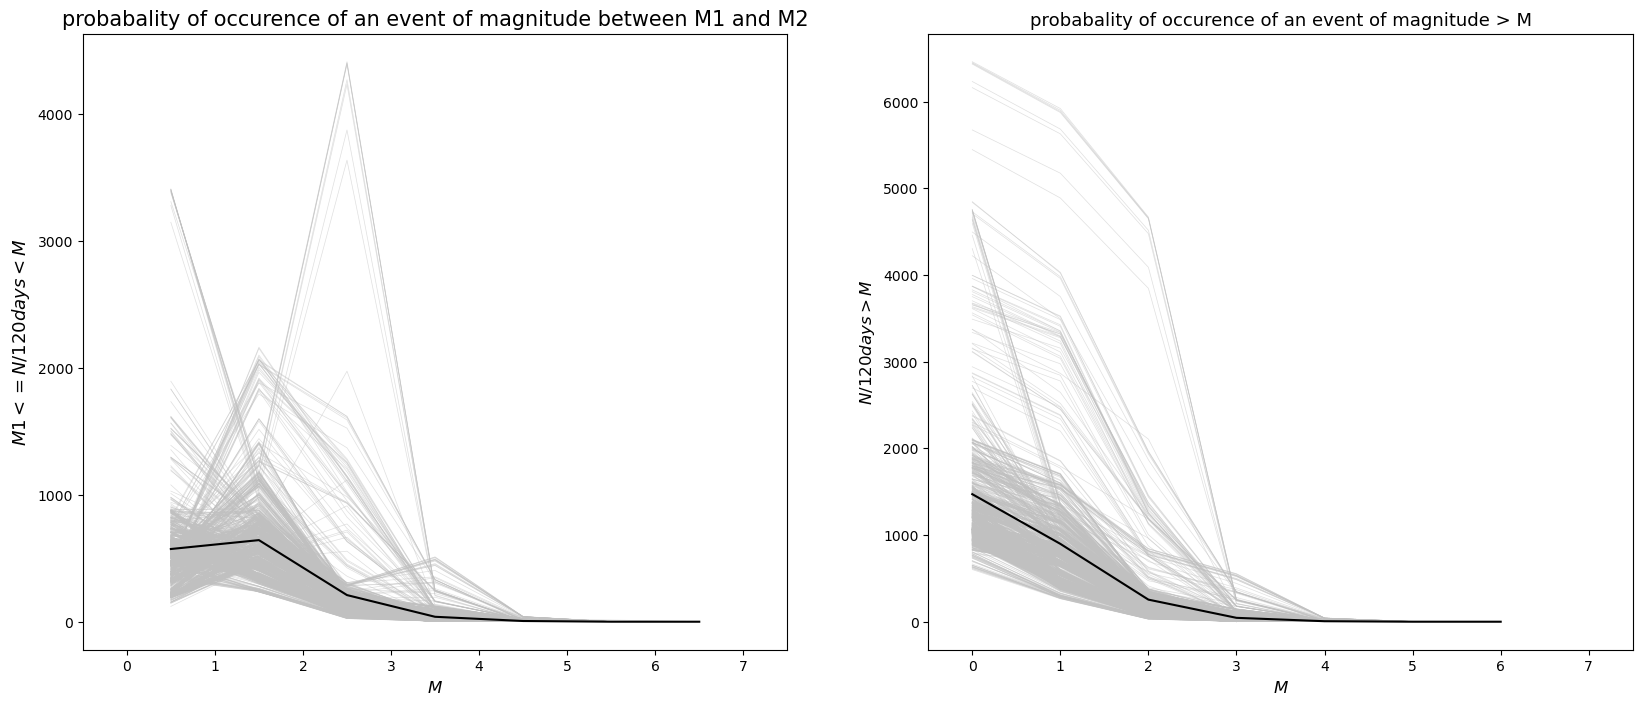

In [3]:
mag_range = np.arange(0, 7, 1)
files = glob.glob("/home/iganesh/venusquakes/data_120days_2000_2021/*.xml")
pdf_arr = np.zeros((len(files), 7), dtype = np.float32)
cdf_arr = np.zeros((len(files), 7), dtype = np.float32)

fig, ax = plt.subplots(1,2, figsize=(20, 8))
markersize = 10

for i in range(len(files)):
    mag = []
    cat = obspy.read_events(files[i])
    for ev in cat:
        mag.append(ev.magnitudes[0].mag)
    mag_arr = np.array(mag)
    cdf_arr[i] = num_events_cum(mag_range, mag_arr)
    pdf_arr[i] = num_events_int(mag_range, mag_arr) 
    ax[1].plot(mag_range[np.where(cdf_arr[i]!=0.0)], cdf_arr[i][np.where(cdf_arr[i]!=0.0)], "-", c='silver', markersize = markersize, alpha = 0.5, linewidth=0.5)
    ax[0].plot(mag_range[np.where(pdf_arr[i]!=0.0)]+0.5, pdf_arr[i][np.where(pdf_arr[i]!=0.0)], "-", c='silver', markersize = markersize, alpha = 0.5, linewidth=0.5)

ax[0].plot(mag_range+0.5, np.mean(pdf_arr, axis = 0), "-", c='black')
ax[1].plot(mag_range, np.mean(cdf_arr, axis = 0), "-", c='black')
    
# ax.set_xscale('log',base=10) 
# ax.set_yscale('log',base=10)
ax[0].set_xlim(-0.5,7.5)
ax[1].set_xlim(-0.5,7.5)
# ax.tick_params(axis='both', which='major', labelsize=13)
# ax.legend(fontsize=12)
ax[0].set_xlabel(r'$M$', fontsize=12)
ax[0].set_ylabel(r'$ M1 <= N/120 days < M$', fontsize=13)
ax[0].set_title("probabality of occurence of an event of magnitude between M1 and M2", fontsize=15)
ax[1].set_xlabel(r'$M$', fontsize=12)
ax[1].set_ylabel(r'$ N/120 days > M$', fontsize=12)
ax[1].set_title("probabality of occurence of an event of magnitude > M", fontsize=13)
plt.show()

/tmp/ipykernel_196/978679507.py:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_xlim(-0.5,7.5)
/tmp/ipykernel_196/978679507.py:29: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_xlim(-0.5,7.5)


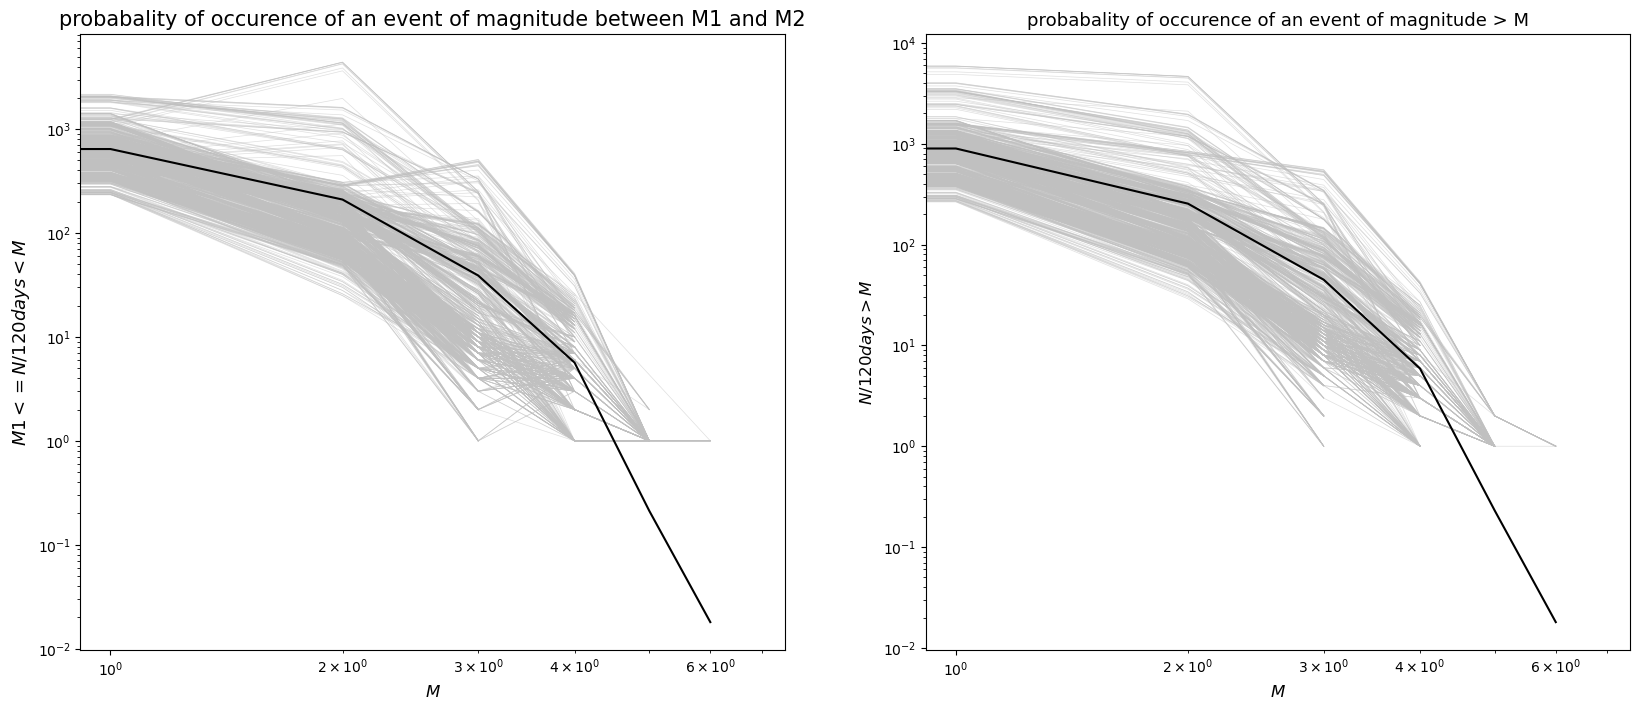

In [4]:
# mag_range = np.arange(0, 7, 1)
# files = glob.glob("/home/iganesh/venusquakes/data_60days/*.xml")
# pdf_arr = np.zeros((len(files), 7), dtype = np.float32)
# cdf_arr = np.zeros((len(files), 7), dtype = np.float32)

fig, ax = plt.subplots(1,2, figsize=(20, 8))
markersize = 10

for i in range(len(files)):
    # mag = []
    # cat = obspy.read_events(files[i])
    # for ev in cat:
    #     mag.append(ev.magnitudes[0].mag)
    # mag_arr = np.array(mag)
    # cdf_arr[i] = num_events_cum(mag_range, mag_arr)
    # pdf_arr[i] = num_events_int(mag_range, mag_arr) 
    ax[1].plot(mag_range[np.where(cdf_arr[i]!=0.0)], cdf_arr[i][np.where(cdf_arr[i]!=0.0)], "-", c='silver', markersize = markersize, alpha = 0.5, linewidth=0.5)
    ax[0].plot(mag_range[np.where(pdf_arr[i]!=0.0)], pdf_arr[i][np.where(pdf_arr[i]!=0.0)], "-", c='silver', markersize = markersize, alpha = 0.5, linewidth=0.5)

ax[0].plot(mag_range, np.mean(pdf_arr, axis = 0), "-", c='black')
ax[1].plot(mag_range, np.mean(cdf_arr, axis = 0), "-", c='black')
    

ax[0].set_xscale('log',base=10) 
ax[0].set_yscale('log',base=10)
ax[1].set_xscale('log',base=10) 
ax[1].set_yscale('log',base=10)
ax[0].set_xlim(-0.5,7.5)
ax[1].set_xlim(-0.5,7.5)
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=10)
# ax.legend(fontsize=12)
ax[0].set_xlabel(r'$M$', fontsize=12)
ax[0].set_ylabel(r'$ M1 <= N/120 days < M$', fontsize=13)
ax[0].set_title("probabality of occurence of an event of magnitude between M1 and M2", fontsize=15)
ax[1].set_xlabel(r'$M$', fontsize=12)
ax[1].set_ylabel(r'$ N/120 days > M$', fontsize=12)
ax[1].set_title("probabality of occurence of an event of magnitude > M", fontsize=13)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


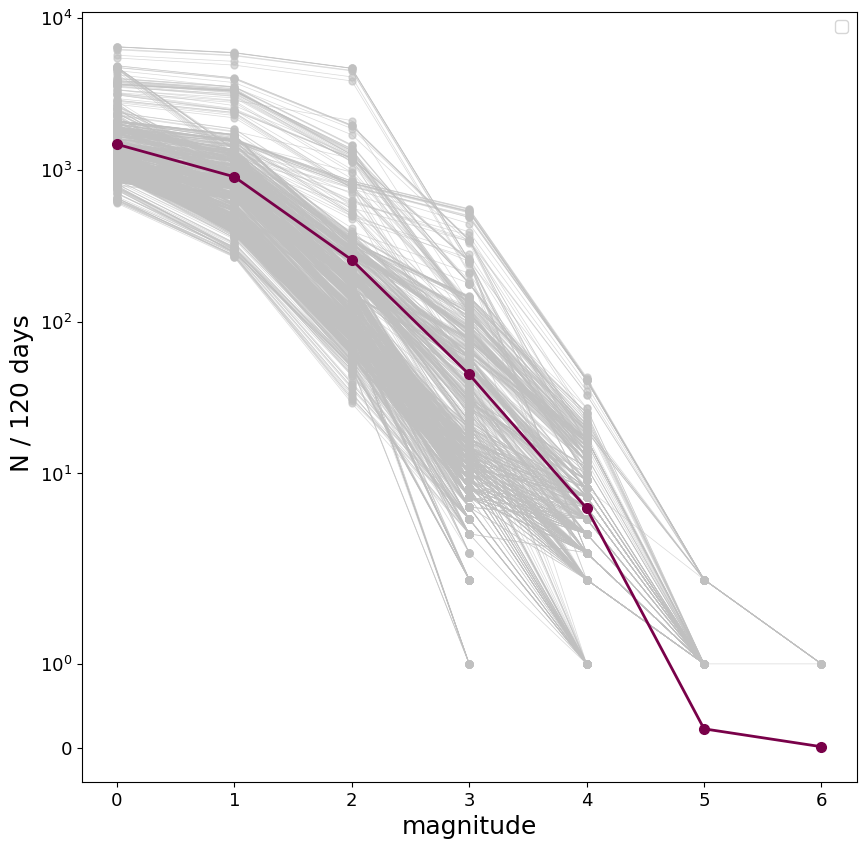

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
markersize = 10

for i in range(len(files)):
    # mag = []
    # cat = obspy.read_events(files[i])
    # for ev in cat:
    #     mag.append(ev.magnitudes[0].mag)
    # mag_arr = np.array(mag)
    # cdf_arr[i] = num_events_cum(mag_range, mag_arr)
    # pdf_arr[i] = num_events_int(mag_range, mag_arr) 
    ax.plot(mag_range[np.where(cdf_arr[i]!=0.0)], cdf_arr[i][np.where(cdf_arr[i]!=0.0)], "o-", c='silver', markersize = 5, alpha = 0.6, linewidth=0.5)
    # ax.plot(np.log10(mag_range), np.log10(cdf_arr[i]), "o-", c='silver', markersize = 5, alpha = 0.5, linewidth=0.5)
   

ax.plot(mag_range, np.mean(cdf_arr, axis = 0), "o-", c='#790149', markersize = 7, linewidth=2)
    
plt.yscale('symlog', base=10)
# ax.set_xscale('log',base=10) 
# ax.set_yscale('log',base=10)

# ax.set_xlim(-0.5,7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=12)
ax.set_xlabel("magnitude", fontsize=18)
ax.set_ylabel(" N / 120 days", fontsize=18)
# ax.set_title("probabality of occurence of an event of magnitude > M", fontsize=13)
plt.savefig("seis_60days.png")
plt.show()

In [52]:
print(np.mean(pdf_arr, axis = 0))
print(np.mean(cdf_arr, axis = 0))
print(mag_range)

[5.73310e+02 6.43360e+02 2.10038e+02 3.89750e+01 5.66000e+00 2.12000e-01
 1.80000e-02]
[1.471573e+03 8.982630e+02 2.549030e+02 4.486500e+01 5.890000e+00
 2.300000e-01 1.800000e-02]
[0 1 2 3 4 5 6]


In [ ]:
cat_temp1 = obspy.read_events("/home/iganesh/venusquakes/data_60days/2010-01-02_20_18_54_712311.xml")
# ev_temp = cat_temp[0]
for i in range(600):
    ev = cat_temp[i]
    print(ev.magnitudes[0].magnitude_type, ev.magnitudes[0].mag, ev.focal_mechanisms)

In [ ]:
print(np.mean(pdf_arr, axis = 0), np.mean(cdf_arr, axis = 0))